In [15]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1 загружаем данные
loads = pd.read_csv(r"C:\Users\79524\Downloads\loads.csv")
players = pd.read_csv(r"C:\Users\79524\Downloads\players.csv")
sessions = pd.read_csv(r"C:\Users\79524\Downloads\sessions.csv")

In [3]:
# добавляем информацию в таблицу loads об уникальном идентификаторе игрока
merged_loads = pd.merge(loads, players, on=['net_id', 'net_type'], how='inner')
merged_loads = merged_loads[['inner_id', 'time']]

In [4]:
merged_loads['time'] = pd.to_datetime(merged_loads['time'])
sessions['login_time'] = pd.to_datetime(sessions['login_time'], unit='s')

In [6]:
# 2. Вычисляем время следующего подключения
ranked_loads = merged_loads.sort_values(['inner_id', 'time']).copy() # Сортируем!
ranked_loads['next_load_time'] = ranked_loads.groupby('inner_id')['time'].shift(-1)
ranked_loads = ranked_loads.rename(columns={'time': 'load_time'}).reset_index(drop=True)

In [7]:
# 3. Проверка сессий 

# Сортируем датафреймы по времени
ranked_loads = ranked_loads.sort_values('load_time')
sessions_df = sessions.sort_values('login_time')

In [8]:
# Объединяем таблицы с помощью merge_asof (ищем ближайшую сессию ПОСЛЕ начала загрузки)
merged_df = pd.merge_asof(
    ranked_loads, sessions_df,
    left_on='load_time', right_on='login_time',
    left_by='inner_id', right_by='player_id',
    direction='forward'
).drop(columns=['player_id'])

# Проверяем, попадает ли login_time в интервал [load_time, next_load_time)
merged_df['has_session'] = (
    merged_df['login_time'].notna() & # Нашли сессию
    (merged_df['next_load_time'].isnull() | (merged_df['login_time'] < merged_df['next_load_time'])) # login_time до next_load_time
).astype(int)

result_df = merged_df[['inner_id', 'load_time', 'has_session']]

In [29]:
df = result_df.copy()
df['load_time'] = df['load_time'].dt.date

In [31]:
# маркируем подключения
df_count = df.groupby(['load_time']).agg({'has_session':'count'}).reset_index()
df_1 = df.query("has_session == 1").groupby(['load_time']).agg({'has_session':'count'}).reset_index()
df_0 = df.query("has_session == 0").groupby(['load_time']).agg({'has_session':'count'}).reset_index()

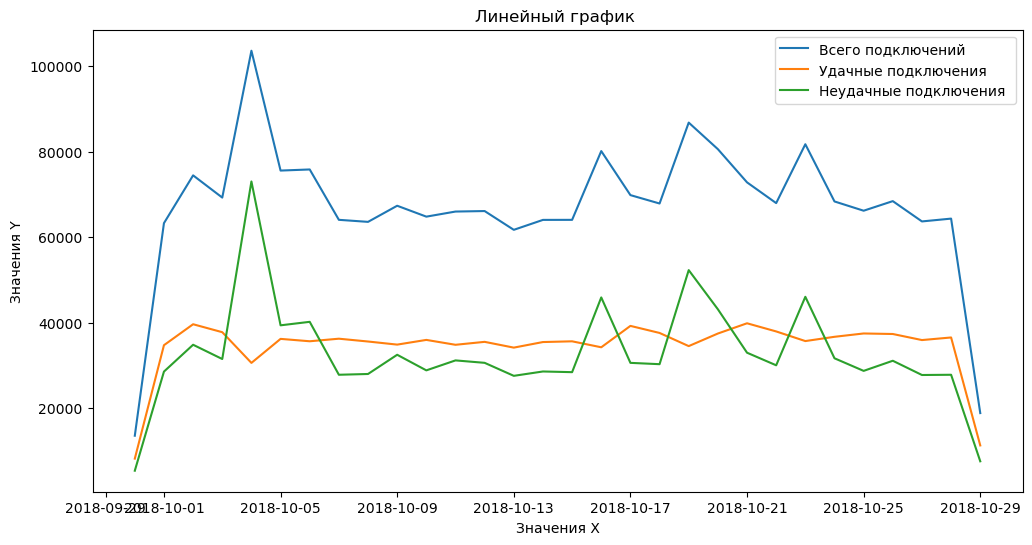

In [34]:
# Строим график
plt.figure(figsize=(12, 6))
sns.lineplot(x='load_time', y='has_session', data=df_count, label='Всего подключений')
sns.lineplot(x='load_time', y='has_session', data=df_1, label='Удачные подключения')
sns.lineplot(x='load_time', y='has_session', data=df_0, label='Неудачные подключения ')

plt.title("Линейный график ")
plt.xlabel("Значения X")
plt.ylabel("Значения Y")
plt.show()

#### Анализ доступности сервиса

1. Введение:

Цель данного анализа — оценить доступность сервиса, выявить наличие проблем и определить влияние обновлений на этот показатель. Для этого мы проанализировали данные о подключениях, игровых сессиях и пользователях, визуализировав результаты для наглядности.

2. Описание данных:

Анализ основан на данных из трех таблиц базы данных `bottle_tz`:

* `loads`: Информация о попытках подключения игроков.
* `players`: Справочник зарегистрированных игроков.
* `sessions`: Данные об игровых сессиях.

3. Методология анализа:

Для определения успешности подключений мы исходили из предположения, что каждому успешному подключению соответствует одна уникальная игровая сессия, начинающаяся непосредственно после подключения.  

Для проверки этого предположения мы выполнили следующие шаги:

1. Объединили таблицы `loads` и `players` по идентификатору пользователя, чтобы связать каждое подключение с конкретным игроком.
2. Для каждого подключения определили время следующей попытки подключения этого же пользователя. Это позволило установить временные рамки, в которых должна находиться соответствующая игровая сессия.
3. На основе полученных временных рамок и идентификатора пользователя мы проверили наличие соответствующей сессии в таблице `sessions`. Подключения, для которых не удалось найти уникальную последующую сессию, были классифицированы как неудачные.

4. Результаты и их интерпретация:

Построенный график демонстрирует динамику успешных и неудачных подключений. Видно, что доля неудачных подключений достигает ~50%, что является критическим показателем для любого онлайн-сервиса.  

Всплески неудачных подключений, вероятно, связаны с проблемами доступности сервиса. Последующие обновления, по-видимому, временно снижали количество ошибок, однако не решали проблему полностью, и показатель возвращался к прежнему высокому уровню. Это говорит о том, что обновления устраняли лишь симптомы, а не первопричину проблемы.

5. Вывод:

Доступность сервиса находится на неприемлемо низком уровне. Необходимы комплексные меры для решения этой проблемы. Текущая стратегия обновлений неэффективна и позволяет лишь кратковременно снизить количество ошибок. Целевой показатель доли неудачных подключений должен быть не более 10%. Достижение этой цели требует глубокого анализа причин возникновения ошибок и разработки глобального решения.